In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_data = pd.read_csv('Traindata.csv')
datasetRetail = pd.read_csv('DataSetRetail.csv')

In [ ]:
# Checking for if any missing values and data types
print(train_data.info())
print(datasetRetail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   record_ID        13860 non-null  int64  
 1   week             13860 non-null  object 
 2   store_id

In [ ]:
# Convert date columns to datetime
train_data['week'] = pd.to_datetime(train_data['week'], format='%d-%m-%Y')


In [ ]:
# Handle missing data if any
train_data.fillna(0, inplace=True)

In [ ]:
#Create features (e.g., week, year)
train_data['year'] = train_data['week'].dt.year
train_data['week_num'] = train_data['week'].dt.isocalendar().week

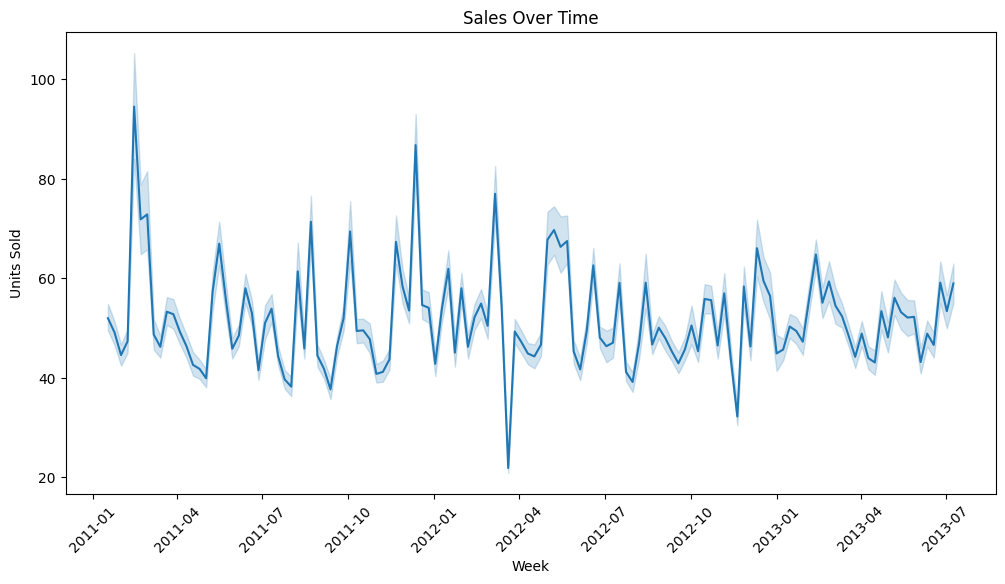

In [ ]:
# Visualize sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='units_sold', data=train_data)
plt.title('Sales Over Time')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.show()

<ipython-input-14-b5001c56fa56>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


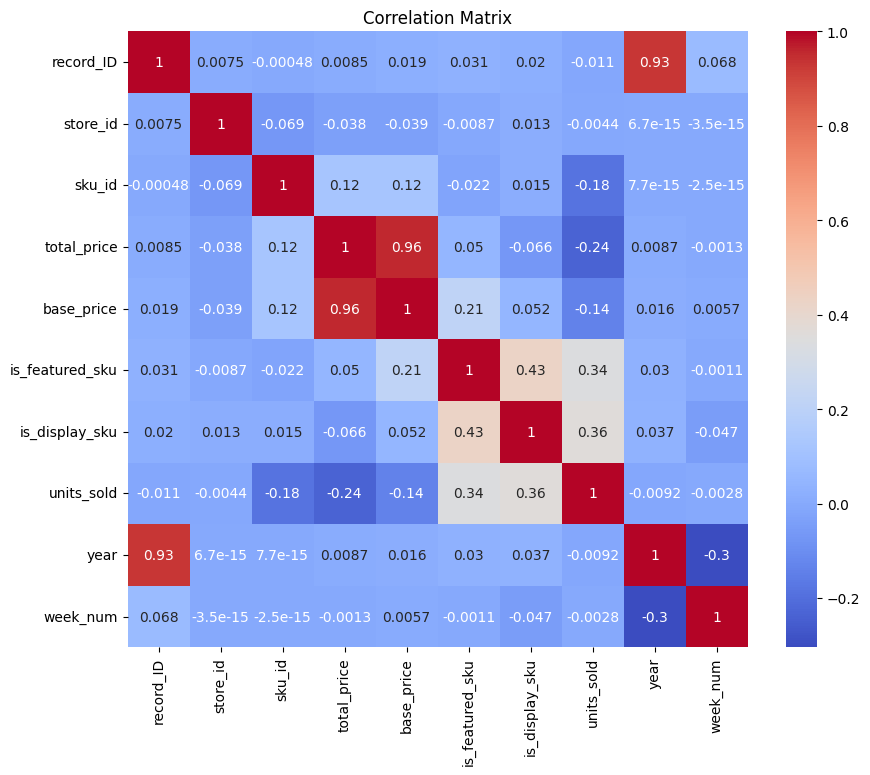

In [ ]:
# Explore correlations
correlation_matrix = train_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# import pandas as pd
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

# # Load the training data and the data to make predictions on
# train_data = pd.read_csv('Traindata.csv')
# predict_data = pd.read_csv('DataSetRetail.csv')

# # Group the training data by 'sku_id' and 'store_id' and create separate forecasts
# predictions = pd.DataFrame()

# for (sku_id, store_id), group in train_data.groupby(['sku_id', 'store_id']):
#     # Set an integer index for the group
#     group = group.reset_index()

#     # Fit the Holt-Winters model on the group
#     model = ExponentialSmoothing(group['units_sold'], seasonal='add', seasonal_periods=12, trend='add', damped=True)
#     model_fit = model.fit()

#     # Generate forecasts for the next 12 periods
#     forecast = model_fit.forecast(steps=12)

#     # Add the forecasts to the predictions dataframe
#     forecast_df = pd.DataFrame({'record_ID': range(1, 13), 'units_sold': forecast})
#     forecast_df['sku_id'] = sku_id
#     forecast_df['store_id'] = store_id
#     predictions = predictions.append(forecast_df, ignore_index=True)

# # Save the predictions in the required format with 'record_ID' and 'units_sold' columns
# predictions = predictions[['record_ID', 'units_sold', 'sku_id', 'store_id']]
# predictions.to_csv('predictions.csv', index=False)

**High level Approach**

This problem was approached as a regression task with the target variable being 'units_sold.' Several new features were generated to enhance the predictive power of the models:


1. Created features that count the number of records for each unique combination of 'sku-id,' 'store-id,' and both.

2. Computed the average units sold for each unique combination of 'sku-id,' 'store-id,' and both.

3. Calculated the average base-price and total-price for each unique combination of 'sku-id,' 'store-id,' and both.

4. Included the week of the year as a feature.

5. Added a feature to represent the week number from the beginning of the dataset.

6. Introduced a feature for the week of the month.

7. Used sine and cosine transformations on the week number to capture the cyclic nature of time.

8. Computed the percentage difference between the base price and total price as a feature.
Categorical encoding was applied to 'sku-id' and 'store-id' using the MEstimateEncoder.

For model training, both Random Forest and LightGBM Regressors were employed. Additionally, model tuning was performed to optimize their performance.

In [ ]:
!pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score,RepeatedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

import xgboost as xgb
import lightgbm as lgb
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge,LogisticRegressionCV,RidgeCV,LassoCV,ElasticNetCV,OrthogonalMatchingPursuit,ElasticNet,LassoLarsCV,BayesianRidge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC,SVR
from scipy import stats
from scipy.stats import norm, skew
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge


from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from scipy.special import boxcox1p
from bayes_opt import BayesianOptimization

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
train=pd.read_csv('Traindata.csv')
test=pd.read_csv('DataSetRetail.csv')
submission=pd.read_csv('submission format.csv')

In [ ]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17-01-2011,8091,216418,99.0375,111.8625,0,0,20
1,2,17-01-2011,8091,216419,99.0375,99.0375,0,0,28
2,3,17-01-2011,8091,216425,133.9500,133.9500,0,0,19
3,4,17-01-2011,8091,216233,133.9500,133.9500,0,0,44
4,5,17-01-2011,8091,217390,141.0750,141.0750,0,0,52


In [ ]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16-07-2013,8091,216418,108.3000,108.3000,0,0
1,212646,16-07-2013,8091,216419,109.0125,109.0125,0,0
2,212647,16-07-2013,8091,216425,133.9500,133.9500,0,0
3,212648,16-07-2013,8091,216233,133.9500,133.9500,0,0
4,212649,16-07-2013,8091,217390,176.7000,176.7000,0,0


In [ ]:
train.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [ ]:
train.dtypes

record_ID            int64
week                object
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
dtype: object

In [ ]:
train.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [ ]:
#Imputing missing value with the relevant total price
train.total_price=train.total_price.fillna(469.5375)

In [ ]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


After analysing the data, the next step is feature engineering

In [ ]:
train.columns

Index(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'units_sold'],
      dtype='object')

In [ ]:
#New Feature Creation functions

def gen_count_id(train,test,col,name):
    temp=train.groupby(col)['record_ID'].count().reset_index().rename(columns={'record_ID':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name]=train[name].astype(float)
    test[name]=test[name].astype(float)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def gen_average_units(train,test,col,name):
    temp=train.groupby(col)['units_sold'].mean().reset_index().rename(columns={'units_sold':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def gen_average_price(train,test,col,price='base_price',name='name'):
    temp=train.groupby(col)[price].mean().reset_index().rename(columns={price:name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [ ]:
train,test = gen_count_id(train,test,col=['sku_id','store_id'],name='count_id_sku_store') #Genearting count of records per 'sku-id & store-id'
train,test = gen_count_id(train,test,col=['sku_id'],name='count_id_sku') #Genearting count of records per 'sku-id'
train,test = gen_count_id(train,test,col=['store_id'],name='count_id_store') #Genearting count of records per 'store-id'

train,test = gen_average_units(train,test,col=['sku_id','store_id'],name='count_sku_store_id') #Genearting average units sold per 'sku-id & store-id'
train,test = gen_average_units(train,test,col=['store_id'],name='count_store_id') #Genearting average units sold per 'store-id'
train,test = gen_average_units(train,test,col=['sku_id'],name='count_sku_id') #Genearting average units sold per 'sku-id'

train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='base_price',name='price_sku_store') #Genearting average base price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='total_price',name='price_to_sku_store') #Genearting average total price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['store_id'],price='base_price',name='price_store_id') #Genearting average base price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='base_price',name='price_sku_id') #Genearting average base price per 'sku-id'
train,test = gen_average_price(train,test,col=['store_id'],price='total_price',name='price_to_store_id') #Genearting average total price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='total_price',name='price_to_sku_id') #Genearting average total price per 'sku-id'

In [ ]:
#Converting week feature
le = OrdinalEncoder()
train['week_1']=le.fit_transform(train['week'])
le = OrdinalEncoder()
test['week_1']=le.fit_transform(test['week'])+130

#Creating week number feature
train['week_num']=train.week_1%52
test['week_num']=test.week_1%52

train['week_num1']=train.week_1%4
test['week_num1']=test.week_1%4

# Encoding 'week' it using sine and cosine transform; considering it as a cyclic feature
train['week_sin'] = np.sin(2 * np.pi * train['week_1'] / 52.143)
train['week_cos'] = np.cos(2 * np.pi * train['week_1'] / 52.143)
test['week_sin'] = np.sin(2 * np.pi * test['week_1'] / 52.143)
test['week_cos'] = np.cos(2 * np.pi * test['week_1'] / 52.143)

#Creating feature: percent difference between base price and checkout price.
train['price_diff_percent'] = (train['base_price'] - train['total_price']) / train['base_price']
test['price_diff_percent'] = (test['base_price'] - test['total_price']) / test['base_price']

In [ ]:
train.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,count_id_sku_store,...,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,week_sin,week_cos,price_diff_percent
150145,212638,09-07-2013,9984,223245,235.8375,235.8375,0,0,38,130.0,...,197.030107,214.878438,186.580537,203.073612,130,26,2,0.043065,-0.999072,0.000000
150146,212639,09-07-2013,9984,223153,235.8375,235.8375,0,0,30,130.0,...,197.030107,220.461485,186.580537,206.303241,130,26,2,0.043065,-0.999072,0.000000
150147,212642,09-07-2013,9984,245338,357.6750,483.7875,1,1,31,130.0,...,197.030107,476.750449,186.580537,432.766248,130,26,2,0.043065,-0.999072,0.260677
150148,212643,09-07-2013,9984,547934,141.7875,191.6625,0,1,12,130.0,...,197.030107,174.616247,186.580537,166.385369,130,26,2,0.043065,-0.999072,0.260223
150149,212644,09-07-2013,9984,679023,234.4125,234.4125,0,0,15,130.0,...,197.030107,209.117532,186.580537,198.309455,130,26,2,0.043065,-0.999072,0.000000


In [ ]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,count_id_sku_store,count_id_sku,...,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,week_sin,week_cos,price_diff_percent
0,212645,16-07-2013,8091,216418,108.3000,108.3000,0,0,130.0,8840.0,...,181.312372,94.688268,172.272756,91.982702,131,27,3,-0.077343,-0.997005,0.0
1,212646,16-07-2013,8091,216419,109.0125,109.0125,0,0,130.0,8710.0,...,181.312372,94.908763,172.272756,92.349162,131,27,3,-0.077343,-0.997005,0.0
2,212647,16-07-2013,8091,216425,133.9500,133.9500,0,0,130.0,8580.0,...,181.312372,128.285210,172.272756,125.156355,131,27,3,-0.077343,-0.997005,0.0
3,212648,16-07-2013,8091,216233,133.9500,133.9500,0,0,130.0,9620.0,...,181.312372,128.101871,172.272756,124.942208,131,27,3,-0.077343,-0.997005,0.0
4,212649,16-07-2013,8091,217390,176.7000,176.7000,0,0,130.0,9100.0,...,181.312372,158.990538,172.272756,150.867334,131,27,3,-0.077343,-0.997005,0.0


In [ ]:
X=train[list(set(train.columns)-set(['record_ID','units_sold','week']))]
Y= np.log1p(train['units_sold'])
X_test=test[list(set(test.columns)-set(['record_ID','week']))]

In [ ]:
X.dtypes

store_id                int64
price_store_id        float64
price_sku_store       float64
count_id_store        float64
count_sku_store_id    float64
price_sku_id          float64
base_price            float64
week_num                int64
price_to_store_id     float64
is_featured_sku         int64
total_price           float64
count_sku_id          float64
count_id_sku          float64
week_1                  int64
is_display_sku          int64
count_store_id        float64
week_cos              float64
sku_id                  int64
price_to_sku_id       float64
count_id_sku_store    float64
price_diff_percent    float64
price_to_sku_store    float64
week_num1               int64
week_sin              float64
dtype: object

In [ ]:
X['sku_id'] = X['sku_id'].astype('category')
X['store_id'] = X['store_id'].astype('category')

In [ ]:
print(len(X_test.columns))
print(len(X.columns))

24
24


In [ ]:
print(X_test.isna().sum().sum())
print(X.isna().sum().sum())

0
0


In [ ]:
category_list=['store_id','sku_id']

In [ ]:
encoder_final=MEstimateEncoder()
encoder_final.fit(X[category_list], Y)

cat_enc = encoder_final.transform(X[category_list], Y)
continuous_train = X.drop(columns= category_list)
X = pd.concat([cat_enc,continuous_train],axis=1)

test_enc=encoder_final.transform(X_test[category_list])
continuous_test=X_test.drop(columns= category_list)
X_test=pd.concat([test_enc,continuous_test],axis=1)

In [ ]:
X.head()

,store_id,sku_id,price_store_id,price_sku_store,count_id_store,count_sku_store_id,price_sku_id,base_price,week_num,price_to_store_id,...,week_1,is_display_sku,count_store_id,week_cos,price_to_sku_id,count_id_sku_store,price_diff_percent,price_to_sku_store,week_num1,week_sin
0,3.250779,4.201821,181.312372,105.800769,1170.0,26.376923,94.688268,111.8625,1,172.272756,...,1,0,32.805983,0.992749,91.982702,130.0,0.11465,102.117692,1,0.120208
1,3.250779,4.051982,181.312372,105.839135,1170.0,28.307692,94.908763,99.0375,1,172.272756,...,1,0,32.805983,0.992749,92.349162,130.0,0.00000,102.473942,1,0.120208
2,3.250779,3.303344,181.312372,131.204135,1170.0,25.669231,128.285210,133.9500,1,172.272756,...,1,0,32.805983,0.992749,125.156355,130.0,0.00000,126.671538,1,0.120208
3,3.250779,3.715659,181.312372,129.916154,1170.0,29.107692,128.101871,133.9500,1,172.272756,...,1,0,32.805983,0.992749,124.942208,130.0,0.00000,126.167308,1,0.120208
4,3.250779,3.850743,181.312372,164.439519,1170.0,29.469231,158.990538,141.0750,1,172.272756,...,1,0,32.805983,0.992749,150.867334,130.0,0.00000,152.968269,1,0.120208


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150150 entries, 0 to 150149
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   store_id            150150 non-null  float64
 1   sku_id              150150 non-null  float64
 2   price_store_id      150150 non-null  float64
 3   price_sku_store     150150 non-null  float64
 4   count_id_store      150150 non-null  float64
 5   count_sku_store_id  150150 non-null  float64
 6   price_sku_id        150150 non-null  float64
 7   base_price          150150 non-null  float64
 8   week_num            150150 non-null  int64  
 9   price_to_store_id   150150 non-null  float64
 10  is_featured_sku     150150 non-null  int64  
 11  total_price         150150 non-null  float64
 12  count_sku_id        150150 non-null  float64
 13  count_id_sku        150150 non-null  float64
 14  week_1              150150 non-null  int64  
 15  is_display_sku      150150 non-nul

In [ ]:
X_test.head()

,store_id,sku_id,price_store_id,price_sku_store,count_id_store,count_sku_store_id,price_sku_id,base_price,week_num,price_to_store_id,...,week_1,is_display_sku,count_store_id,week_cos,price_to_sku_id,count_id_sku_store,price_diff_percent,price_to_sku_store,week_num1,week_sin
0,3.250779,4.201821,181.312372,105.800769,1170.0,26.376923,94.688268,108.3000,27,172.272756,...,131,0,32.805983,-0.997005,91.982702,130.0,0.0,102.117692,3,-0.077343
1,3.250779,4.051982,181.312372,105.839135,1170.0,28.307692,94.908763,109.0125,27,172.272756,...,131,0,32.805983,-0.997005,92.349162,130.0,0.0,102.473942,3,-0.077343
2,3.250779,3.303344,181.312372,131.204135,1170.0,25.669231,128.285210,133.9500,27,172.272756,...,131,0,32.805983,-0.997005,125.156355,130.0,0.0,126.671538,3,-0.077343
3,3.250779,3.715659,181.312372,129.916154,1170.0,29.107692,128.101871,133.9500,27,172.272756,...,131,0,32.805983,-0.997005,124.942208,130.0,0.0,126.167308,3,-0.077343
4,3.250779,3.850743,181.312372,164.439519,1170.0,29.469231,158.990538,176.7000,27,172.272756,...,131,0,32.805983,-0.997005,150.867334,130.0,0.0,152.968269,3,-0.077343


Buidling the model

In [ ]:
X.columns

Index(['store_id', 'sku_id', 'price_store_id', 'price_sku_store',
       'count_id_store', 'count_sku_store_id', 'price_sku_id', 'base_price',
       'week_num', 'price_to_store_id', 'is_featured_sku', 'total_price',
       'count_sku_id', 'count_id_sku', 'week_1', 'is_display_sku',
       'count_store_id', 'week_cos', 'price_to_sku_id', 'count_id_sku_store',
       'price_diff_percent', 'price_to_sku_store', 'week_num1', 'week_sin'],
      dtype='object')

In [ ]:
del X['week_num1']

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2,random_state=23)

In [ ]:
len(x_train.columns)

23

In [ ]:
rf_base = RandomForestRegressor()
rf_base.fit(x_train,y_train)


rf_tuned = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=True, random_state=None,
                      verbose=0, warm_start=False)
rf_tuned.fit(x_train,y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=10,
                      n_estimators=600, oob_score=True)

In [ ]:
model_lgb_base=lgb.LGBMRegressor(objective='regression')
model_lgb_base.fit(x_train,y_train)

model_lgb_tuned=lgb.LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_estimators=200, n_jobs=-1,
              num_leaves=1200, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

model_lgb_tuned.fit(x_train,y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, feature_fraction=0.5,
              max_depth=30, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_estimators=200, num_leaves=1200)

In [ ]:
prediction_rfb_valid=rf_base.predict(x_valid)
prediction_rft_valid=rf_tuned.predict(x_valid)
prediction_lgbmb_valid=model_lgb_base.predict(x_valid)
prediction_lgbmt_valid=model_lgb_tuned.predict(x_valid)

rf_base_msle=100*mean_squared_log_error(y_valid,prediction_rfb_valid)
rf_tuned_msle=100*mean_squared_log_error(y_valid,prediction_rft_valid)
lgbm_base_msle=100*mean_squared_log_error(y_valid,prediction_lgbmb_valid)
lgbm_tuned_msle=100*mean_squared_log_error(y_valid,prediction_lgbmt_valid)

prediction_ensemble_base=(((1-rf_base_msle)*prediction_rfb_valid)+((1-lgbm_base_msle)*prediction_lgbmb_valid))/(2-rf_base_msle-lgbm_base_msle)
prediction_ensemble_tuned=(((1-rf_tuned_msle)*prediction_rft_valid)+((1-lgbm_tuned_msle)*prediction_lgbmt_valid))/(2-rf_tuned_msle-lgbm_tuned_msle)

ensemble_base_msle=100*mean_squared_log_error(y_valid,prediction_ensemble_base)
ensemble_tuned_msle=100*mean_squared_log_error(y_valid,prediction_ensemble_tuned)

RF Base: 0.84662639504341; RF Tuned: 0.843420312724732

LGBM Base: 0.9034433568006958; LGBM Tuned: 0.697141794951405

Ensemble Base: 0.8185060670127743; Ensemble Tuned: 0.7261311054985061

upon running the above code we get the above values

In [ ]:
model = lgb.LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_estimators=100, n_jobs=-1,
              num_leaves=1400, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

model.fit(X,Y)

LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, feature_fraction=0.5,
              max_depth=30, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, num_leaves=1400)

In [ ]:
prediction=model.predict(X_test)

In [ ]:
final_prediction=np.round(np.expm1(prediction))
submission['units_sold']=final_prediction

In [ ]:
submission.to_csv('sales_forcast_prediction.csv', index=False)